# IMPORTS

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mae, mse
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


# Utils

In [7]:
# Function to load and prepare data
def load_data(ticker="^GSPC", start_date='1990-01-02', end_date='2024-03-20', split_date='2023-01-01', apply_filter=False):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Price'] = df['Close']
    df = df[['Price']]
    
    business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    df = df.reindex(business_days).ffill()

    # Convert the DataFrame into a TimeSeries data type
    price_ts = TimeSeries.from_dataframe(df, value_cols=['Price'], fill_missing_dates=True, freq='B')
    if apply_filter:
        price_ts = apply_butterworth_filter(price_ts,debug=True)
    
    # Split the data into train and test TimeSeries
    price_train_ts, price_test_ts = price_ts.split_before(pd.Timestamp(split_date))
    return price_ts, price_train_ts, price_test_ts

def apply_butterworth_filter(time_series: TimeSeries, order: int = 3, critical_frequency: float = 0.05, debug=False) -> TimeSeries:
    """
    Applies a zero-phase Butterworth filter to a given TimeSeries object using filtfilt.

    Parameters:
    - time_series: The TimeSeries object to filter.
    - order: The order of the Butterworth filter (default is 3).
    - critical_frequency: The critical frequency for the filter, normalized (default is 0.05).
    - debug: If True, print debug information.

    Returns:
    - A new TimeSeries object with the filtered data.
    """
    # Extract values and timestamps from the TimeSeries object
    values = time_series.values().flatten()
    times = time_series.time_index

    # Design the Butterworth filter
    b, a = butter(order, critical_frequency, btype='low', analog=False)

    # Apply the filter to the data using filtfilt for zero-phase filtering
    filtered_values = filtfilt(b, a, values)

    # Create a new TimeSeries object with the filtered data
    filtered_series = TimeSeries.from_times_and_values(times, filtered_values, freq=time_series.freq_str)

    if debug:
        print("✅ Zero-phase Butterworth filter applied.")

    return filtered_series

def train_linear_regression(train_ts):
    model = LinearRegressionModel(lags=60)
    model.fit(train_ts)
    return model

def plot_predictions(test_ts, predicted_ts, title=""):
    plt.figure(figsize=(12, 6))
    test_ts.plot(label='Actual')
    predicted_ts.plot(label='Forecast')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_full_series(full_ts, train_ts, test_ts, predicted_ts, title=""):
    plt.figure(figsize=(15, 8))
    full_ts.plot(label='Full Series')
    test_ts.plot(label='Test Series', color='orange')
    predicted_ts.plot(label='Forecast', color='red')
    plt.axvline(x=train_ts.end_time(), color='green', linestyle='--', label='Train/Test Split')
    plt.title(title)
    plt.legend()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


✅ Zero-phase Butterworth filter applied.
MSE on test set: 31083.172306902736
MAE on test set: 132.00663624314765


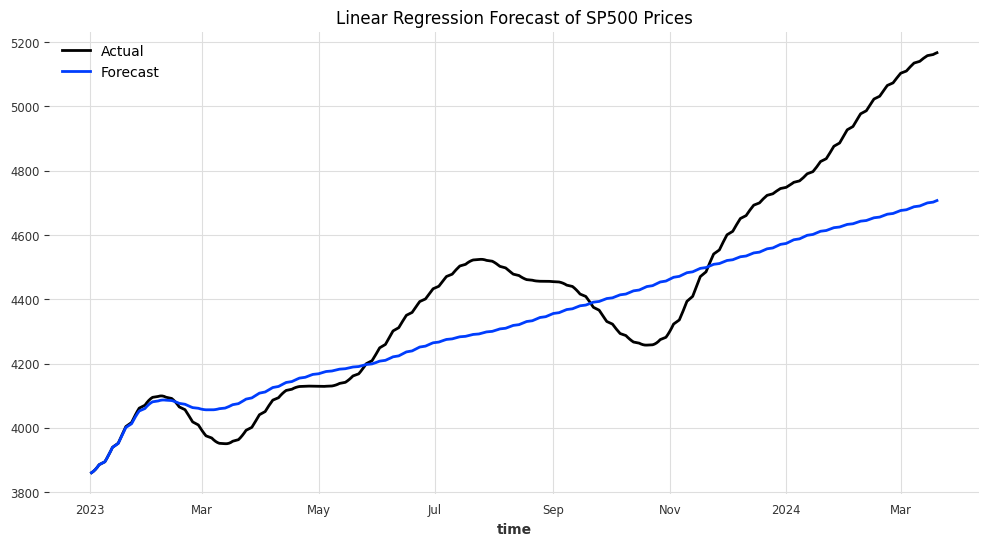

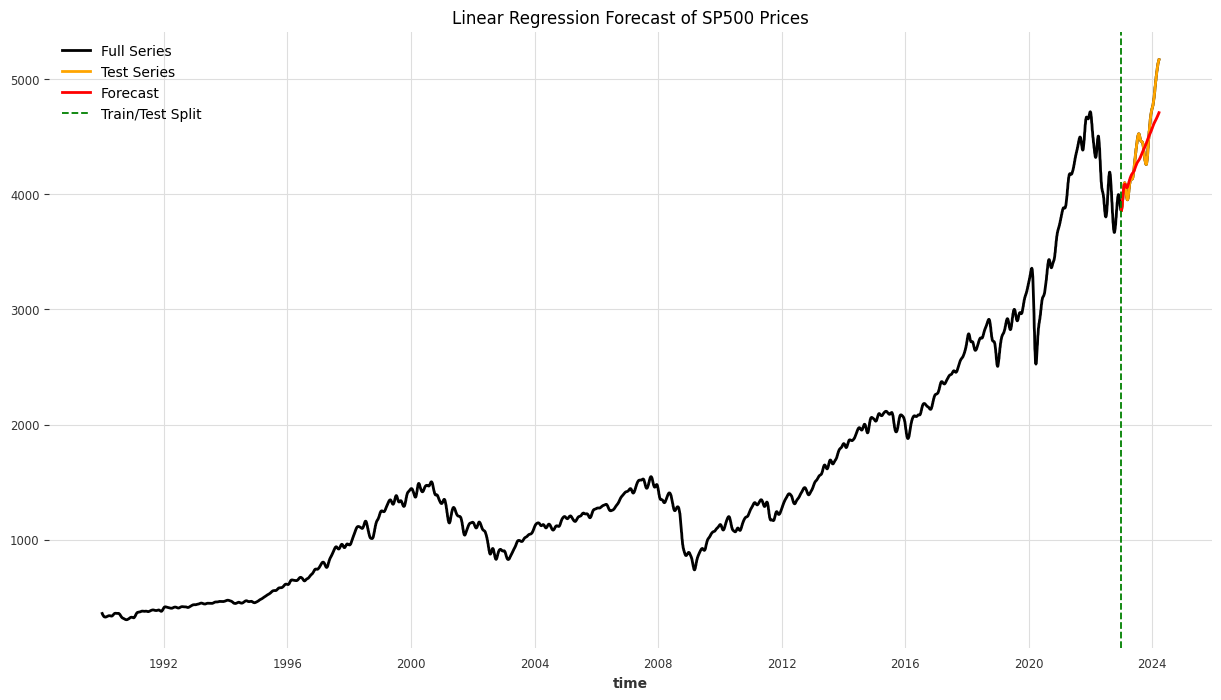

In [8]:
full_ts, price_train_ts, price_test_ts = load_data(split_date="2023-01-01", apply_filter=True)
model = train_linear_regression(price_train_ts)
predictions_ts = model.predict(len(price_test_ts))

print(f"MSE on test set: {mse(price_test_ts, predictions_ts)}")
print(f"MAE on test set: {mae(price_test_ts, predictions_ts)}")

plot_predictions(price_test_ts, predictions_ts, title="Linear Regression Forecast of SP500 Prices")
plot_full_series(full_ts, price_train_ts, price_test_ts, predictions_ts, title="Linear Regression Forecast of SP500 Prices")